# Deep Learning for NLP

**Fake news classifier**: Train a text classification model to detect fake news articles!

* Download the dataset here: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset


In [ ]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!pip install transformers

     |████████████████████████████████| 3.8 MB 12.2 MB/s 
     |████████████████████████████████| 596 kB 39.0 MB/s 
     |████████████████████████████████| 895 kB 46.9 MB/s 
     |████████████████████████████████| 6.5 MB 43.4 MB/s 
     |████████████████████████████████| 77 kB 7.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
import pandas as pd
import numpy as np

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
import gensim
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences

import sklearn
import itertools
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# from tqdm.notebook import tqdm
from tqdm.auto import tqdm
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import AdamW

from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import get_scheduler


from IPython.display import display, clear_output

print('Done')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
Done


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
true_path = '/content/drive/MyDrive/archive/True.csv'
fake_path = '/content/drive/MyDrive/archive/Fake.csv'

true_df = pd.read_csv(true_path)
fake_df = pd.read_csv(fake_path)

display(true_df)
display(fake_df)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


Data Visualization

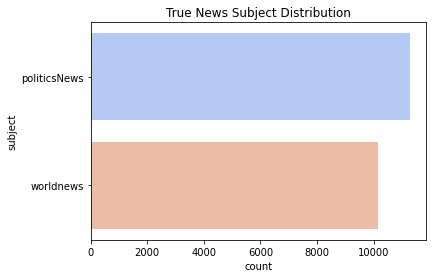

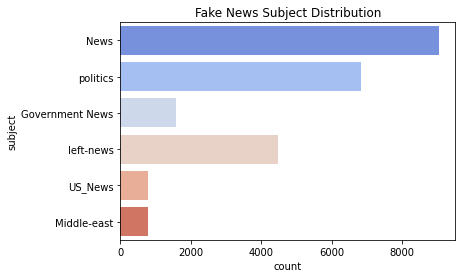

In [ ]:
sns.countplot(y="subject", palette="coolwarm", data=true_df).set_title('True News Subject Distribution')
plt.show()

sns.countplot(y="subject", palette="coolwarm", data=fake_df).set_title('Fake News Subject Distribution')
plt.show()

Word Cloud

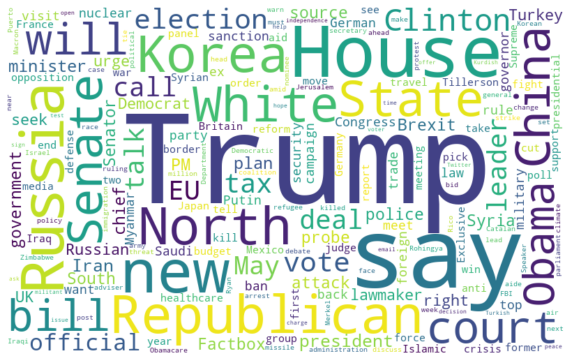

In [ ]:
real_titles = true_df.title
real_titles_ls = [text for text in real_titles]
# print(alls)
real_all_words = ' '.join(real_titles)
wordcloud_real = WordCloud(background_color='white',
    width= 800, height= 500,
    max_font_size = 180,
    collocations = False).generate(real_all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis("off")
plt.show()

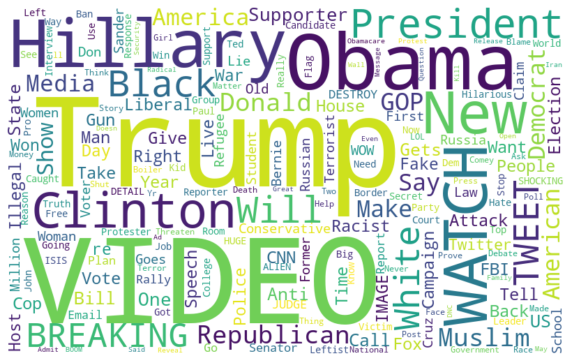

In [ ]:
fake_titles = fake_df.title
fake_titles_ls = [text for text in fake_titles]
# print(alls)
fake_all_words = ' '.join(fake_titles)
wordcloud_fake = WordCloud(background_color='white',
    width= 800, height= 500,
    max_font_size = 180,
    collocations = False).generate(fake_all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.show()

Data Preprocessing

In [ ]:
# Add Labels to both df
true_df['true'] = 1
fake_df['true'] = 0

# Concat
df = pd.concat([true_df, fake_df])
display(df)

,title,text,subject,date,true
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [ ]:
titles = [text for text in df.title]

max_len = 0
titles_len = []
for title in titles:
    titles_len.append(len(title.split()))
    max_len = max(len(title.split()), max_len)

print('Number of titles:', len(titles))
print('Max length of the titles:', max_len)
print('Mean length of the titles:', np.mean(titles_len))

# plt.figure(figsize=(20,5))
# g = sns.countplot(x=titles_len)
# g.set_xticklabels(g.get_xticklabels(), rotation=50)
# plt.show()

Number of titles: 44898
Max length of the titles: 42
Mean length of the titles: 12.453472315025168


In [ ]:
texts = [text for text in df.text]

max_len = 0
texts_len = []
for text in texts:
    texts_len.append(len(text.split()))
    max_len = max(len(text.split()), max_len)

# g = sns.countplot(x=texts_len)
print('Mean length of the texts:', np.mean(texts_len))

Mean length of the texts: 405.28228428883244


Data Shuffling

In [ ]:
df = df.iloc[:,[0, -1]]

df = shuffle(df).reset_index(drop=True)

display(df)

,title,true
0,France's Macron tells Trump concerned over Jer...,1
1,Head of Syrian opposition's HNC resigns: state...,1
2,What we know so far about the London train bomb,1
3,Turkey turns off Kurdish Rudaw channel in wake...,1
4,South Dakota governor considers transgender ba...,1
...,...,...
44893,Flamboyant Hong Kong businessman David Tang di...,1
44894,"Eurofighter jet crashes in Spain, killing pilot",1
44895,Whoopi Goldberg Opens Up A Can Of Whoop-A** O...,0
44896,Canada says most border-crossing asylum seeker...,1


Splitting into train, test and validation set

In [ ]:
train_val_df = df.sample(frac = 0.8)
test_df = df.drop(train_val_df.index)

train_df = train_val_df.sample(frac = 0.8)
val_df = train_val_df.drop(train_df.index)

# Reset Index
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print('trainset size:', train_df.shape)
print('valset size:', val_df.shape)
print('testset size:', test_df.shape)

trainset size: (28734, 2)
valset size: (7184, 2)
testset size: (8980, 2)


In [ ]:
df = pd.concat([train_df, val_df, test_df])
display(df)

,title,true
0,Death toll from Vietnam storm tops 60 and dams...,1
1,U.S. 'making a lot of progress' on North Korea...,1
2,WHOA! DNC Releases Statement Suggesting Dallas...,0
3,Fox News ‘Expert’ Will Now Be A Prison Expert...,0
4,Trump says he will back away from business to ...,1
...,...,...
8975,A MUST WATCH VIDEO: STEVE BANNON “If you think...,0
8976,MUSLIM MIGRANT WOMAN CAUGHT SPITTING On Angry ...,0
8977,Exclusive: Turkey to deploy troops inside Syri...,1
8978,Canada says most border-crossing asylum seeker...,1


Performing Data Cleaning

In [ ]:
# Obtaining Additional Stopwords From nltk
stop_words = stopwords.words('english')
# Removing Stopwords
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and token not in stop_words:
            result.append(token)
            
    return result


In [ ]:
df['clean'] = df['title'].apply(preprocess)

In [ ]:
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)



total_words = len(list(set(list_of_words)))
total_words

20070

ROBERT

In [ ]:
train_df.to_csv('train.tsv', sep='\t', index=False)
val_df.to_csv('val.tsv', sep='\t', index=False)
test_df.to_csv('test.tsv', sep='\t', index=False)

In [ ]:
# roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", #RoBERTa base model
#                                                                     num_labels = 2,  #number of output labels - 0,1 (binary classification)
#                                                                     output_attentions = False,  #model doesnt return attention weights
#                                                                     output_hidden_states = False #model doesnt return hidden states
#                                                                 )
# #RoBERTa tokenizer
# roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=True)
PRETRAINED_MODEL_NAME = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(PRETRAINED_MODEL_NAME, do_lower_case=True)


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
class FakeNewsDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ['train', 'val', 'test']
        self.mode = mode
        # shuffle(df).reset_index(drop=True)
        self.df = shuffle(pd.read_csv('/content/' + mode + '.tsv', sep='\t').fillna("")).reset_index(drop=True)
        self.len = len(self.df)
        self.tokenizer = tokenizer  # ROBERT tokenizer
    
    def __getitem__(self, idx):
        if self.mode == 'test':
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)
        else:
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)
            
        word_pieces = ['[CLS]']
        statement = self.tokenizer.tokenize(statement)
        word_pieces += statement + ['[SEP]']
        len_st = len(word_pieces)
        
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        
        segments_tensor = torch.tensor([0] * len_st, dtype=torch.long)
        
        return (tokens_tensor, segments_tensor, label_tensor)

    def __len__(self):
        return self.len
  
    
trainset = FakeNewsDataset('train', tokenizer=tokenizer)
valset = FakeNewsDataset('val', tokenizer=tokenizer)
testset = FakeNewsDataset('test', tokenizer=tokenizer)

print('trainset size:' , len(trainset.df))
print('valset size:', len(valset.df))
print('testset size:', len(testset.df))

trainset size: 28734
valset size: 7184
testset size: 8980


Observing tensors

In [ ]:
sample_idx = 0

statement, label = trainset.df.iloc[sample_idx].values

tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = " ".join(tokens)

print(f"""original_statement: {statement} tokens: {tokens} label: {label}
-------------------- tokens_tensor: {tokens_tensor} segments_tensor: {segments_tensor} label_tensor: {label_tensor}""")

original_statement: Trump opposes undermining Japan's control of disputed islands: U.S. official tokens: ['<unk>', 'Trump', 'Ġopposes', 'Ġundermining', 'ĠJapan', "'s", 'Ġcontrol', 'Ġof', 'Ġdisputed', 'Ġislands', ':', 'ĠU', '.', 'S', '.', 'Ġofficial', '<unk>'] label: 1
-------------------- tokens_tensor: tensor([    3,  7565, 20408, 19579,  1429,    18,   797,     9, 11164,  8879,
           35,   121,     4,   104,     4,   781,     3]) segments_tensor: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) label_tensor: 1


In [ ]:
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    # Zero Padding
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)
    
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


BATCH_SIZE = 32
trainloader = DataLoader(trainset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
testloader = DataLoader(testset, batch_size=BATCH_SIZE,collate_fn=create_mini_batch)

In [ ]:
data = next(iter(trainloader))

tokens_tensors, segments_tensors, masks_tensors, label_ids = data

print(f"""
tokens_tensors.shape   = {tokens_tensors.shape} 
{tokens_tensors}
------------------------
segments_tensors.shape = {segments_tensors.shape}
{segments_tensors}
------------------------
masks_tensors.shape    = {masks_tensors.shape}
{masks_tensors}
------------------------
label_ids.shape        = {label_ids.shape}
{label_ids}
""")


tokens_tensors.shape   = torch.Size([32, 49]) 
tensor([[    3,  7565,   450,  ...,     0,     0,     0],
        [    3, 47207,  6178,  ...,     0,     0,     0],
        [    3, 37589, 16371,  ...,     0,     0,     0],
        ...,
        [    3, 36015,  6019,  ...,     0,     0,     0],
        [    3,   140, 29261,  ...,     0,     0,     0],
        [    3, 26369, 16024,  ..., 36662,   742,     3]])
------------------------
segments_tensors.shape = torch.Size([32, 49])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
------------------------
masks_tensors.shape    = torch.Size([32, 49])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]])
------------

Model construction

In [ ]:
# roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", #RoBERTa base model
#                                                                     num_labels = 2,  #number of output labels - 0,1 (binary classification)
#                                                                     output_attentions = False,  #model doesnt return attention weights
#                                                                     output_hidden_states = False #model doesnt return hidden states
#                                                                 )
# #RoBERTa tokenizer
# roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=True)

PRETRAINED_MODEL_NAME = "roberta-base"
NUM_LABELS = 2

# model = BertForSequenceClassification.from_pretrained(
#     PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

model = RobertaForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)


clear_output()

print("""
name             module
-----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:16} {}".format(name, module))

model.config


name             module
-----------------------
roberta          RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Fine tuning of ROBERT

In [ ]:
def validation_check(model, valloader):
    true = []
    predictions = []
    model.eval()
    val_accuracy = []
    val_loss = []
    
    loop2 = tqdm(valloader)
    for batch_idx, data in enumerate(loop2):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]
    # for data in valloader:
    #     if next(model.parameters()).is_cuda:
    #         data = [t.to(device) for t in data if t is not None]
            
        # tokens_tensors, segments_tensors, masks_tensors = data[:3]
        test_outputs = model(input_ids=tokens_tensors, 
                    token_type_ids=segments_tensors, 
                    attention_mask=masks_tensors,
                    labels = labels)

        logits = test_outputs[1]
        _, pred = torch.max(logits.data, 1)
        
        # true.extend(labels.cpu().tolist())
        # predictions.extend(pred.cpu().tolist())

        val_accuracy.append(accuracy_score(pred.cpu().tolist() , labels.cpu().tolist()))
        # val_loss.append(loss.item())
        # val_accuracy.append(accuracy_score(predictions,true))

    # val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_accuracy


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)

# model.train()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 5
num_training_steps = num_epochs * len(trainloader)
lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# progress_bar = tqdm(range(num_training_steps))

model.train()

for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0

    loop = tqdm(trainloader)
    for batch_idx, data in enumerate(loop):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]

    
        # optimizer.zero_grad()
        
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)

  

        loss = outputs[0]
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        

        logits = outputs[1]
        _, pred = torch.max(logits.data, 1)
        train_acc = accuracy_score(pred.cpu().tolist() , labels.cpu().tolist())

        train_loss += loss.item()

        # progress_bar.update(1)

        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(acc = train_acc, loss = train_loss)
    
    val_accuracy = validation_check(model, valloader)
    print(f" validation accuracy {val_accuracy} \n")



device: cuda:0


  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

 validation accuracy 0.9998611111111111 



  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

 validation accuracy 0.9998611111111111 



  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

 validation accuracy 0.9997222222222222 



  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

 validation accuracy 0.9997222222222222 



  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

 validation accuracy 0.9997222222222222 



Save Model

In [ ]:
torch.save(model, 'best_model.pth')
print('Model saved!')

Model saved!


Load Model

In [ ]:
model = torch.load('./content/best_model.pth')
model = model.to(device)

FileNotFoundError: ignored

Test

[[0.98158803 0.00970874]
 [0.01841197 0.99029126]]
Acc:  0.9860801781737194


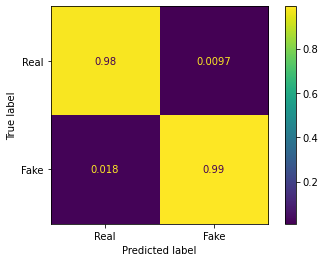

In [ ]:
true=[]
predictions=[]
with torch.no_grad():
    model.eval()
    for data in testloader:
        if next(model.parameters()).is_cuda:
            data = [t.to(device) for t in data if t is not None]
            
        tokens_tensors, segments_tensors, masks_tensors = data[:3]
        test_outputs = model(input_ids=tokens_tensors, 
                    token_type_ids=segments_tensors, 
                    attention_mask=masks_tensors)

        logits = test_outputs[0]
        _, pred = torch.max(logits.data, 1)

        labels = data[3]
        true.extend(labels.cpu().tolist())
        predictions.extend(pred.cpu().tolist())


cm = confusion_matrix(true, predictions, labels=[1, 0], normalize='pred')
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
disp.plot()

print('Acc: ', accuracy_score(predictions,true))

In [ ]:
df = pd.DataFrame({"pred_label": predictions})

df_pred = pd.concat([testset.df.loc[:, ['title']], 
                          testset.df.loc[:, ['true']], 
                          df.loc[:, 'pred_label']], axis=1)
# df_pred.to_csv('bert_1_prec_training_samples.csv', index=False)
df_pred

,title,true,pred_label
0,DIAMOND AND SILK Open Up LARGE Can Of WHOOP A$...,0,0
1,Ukraine president denies hampering anti-corrup...,1,1
2,Some Sept. 11 families join criticism of Trump...,1,1
3,TRUMP HITS BACK After News of North Korea’s Nu...,0,0
4,Trump picks lawyer Ty Cobb to handle Russia probe,1,1
...,...,...,...
8975,Twitter Wishes Lincoln Happy Birthday With Hi...,0,0
8976,CLIMATE CHANGE DENIERS BEWARE: The DOJ Wants T...,0,0
8977,WHO WILL SUPPORT “THE BERN”? New Numbers Show ...,0,0
8978,(VIDEO) DEM PRESIDENTIAL CANDIDATE GIVES UNBEL...,0,0


In [ ]:
print(sklearn.metrics.classification_report(df_pred.true, df_pred.pred_label))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      4732
           1       0.99      0.96      0.98      4248

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



AUC-ROC CURVE

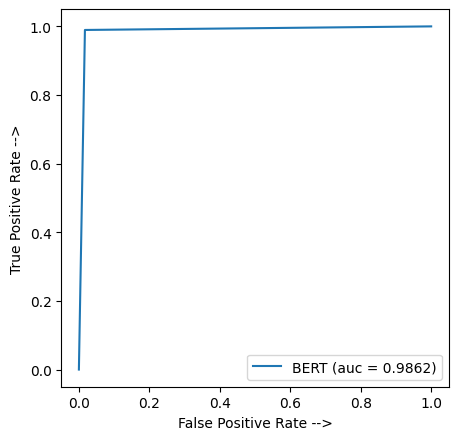

In [ ]:
bert_fpr, bert_tpr, threshold = roc_curve(df_pred.true, df_pred.pred_label)
auc_bert = auc(bert_fpr, bert_tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(bert_fpr, bert_tpr, linestyle='-', label='BERT (auc = %0.4f)' % auc_bert)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

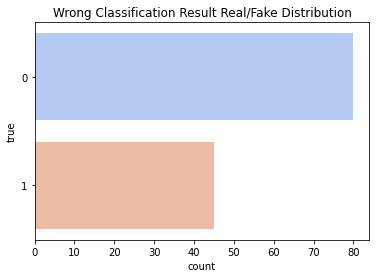

In [ ]:
wrong_df = df_pred[df_pred.true != df_pred.pred_label]
sns.countplot(y="true", palette="coolwarm", data=wrong_df).set_title('Wrong Classification Result Real/Fake Distribution')
plt.show()

In [ ]:
wrong_news = df_pred[df_pred.true != df_pred.pred_label]
print(wrong_news.to_string())

                                                                                               title  true  pred_label
89                       Trump Told FBI To Kill Stories About His Connections To Putin, They Said No     0           1
243                            Bernie Sanders Receives First Endorsement From A Current U.S. Senator     0           1
398                                    Early Voting In North Carolina Shows GREAT NEWS For Democrats     0           1
409                  Florida Continues For-Profit Juvenile Prisons After Years Of Abuses, Corruption     0           1
487                              Trump order frees tax-exempt churches to be more politically active     1           0
530                                            New Report Says Trump Destroyed Scaramucci’s Marriage     0           1
680                      NY prosecutor’s office likely to plot similar course after Bharara’s firing     1           0
818                                     Gun shop